## LIBRARY IMPORTATION

In [407]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import statsmodels
import copy
import math

%matplotlib inline

## Data Processing

In [408]:
x_cli_train = pd.read_csv( 'data_x_train/features/clinical_data_train.csv')
x_cli_train.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


In [409]:
x_cli_train.describe()

,PatientID,Mstage,Nstage,Tstage,age
count,300.000000,300.000000,300.000000,300.000000,284.000000
mean,213.740000,0.040000,0.963333,2.103333,68.766856
std,122.737119,0.314212,1.160378,1.072297,9.587605
min,2.000000,0.000000,0.000000,1.000000,42.513300
25%,106.750000,0.000000,0.000000,1.000000,62.979625
50%,217.000000,0.000000,0.000000,2.000000,69.947300
75%,318.500000,0.000000,2.000000,3.000000,76.201950
max,424.000000,3.000000,3.000000,5.000000,87.126600


In [410]:
x_cli_train.Mstage.value_counts()

Mstage
0    294
3      3
1      3
Name: count, dtype: int64

Nous n'allons pas utiliser cette featurs car elle est quasiment constante et pourrait causer une convergence dans notre modèle

In [411]:
x_cli_train.Nstage.value_counts()

Nstage
0    167
2     76
3     40
1     17
Name: count, dtype: int64

In [412]:
x_cli_train.Tstage.value_counts()

Tstage
2    111
1    105
4     50
3     33
5      1
Name: count, dtype: int64

In [413]:
features = ['Histology','Nstage','Tstage','age']
x_cli_train = x_cli_train.drop(columns='Mstage')
x_cli_train.Histology.value_counts()

Histology
Adenocarcinoma                         80
large cell                             61
squamous cell carcinoma                59
nos                                    38
adenocarcinoma                         21
Squamous cell carcinoma                19
NSCLC NOS (not otherwise specified)     2
Name: count, dtype: int64

In [414]:
x_cli_train['Histology'] = x_cli_train.Histology.apply(lambda x : 0 if x in('Adenocarcinoma', 'adenocarcinoma')
                                                else 1 if x == 'large cell'
                                                else 2 if x in ('squamous cell carcinoma', 'Squamous cell carcinoma')
                                                else 3)
x_cli_train.Histology.value_counts()

Histology
0    101
2     78
1     61
3     60
Name: count, dtype: int64

In [415]:
x_cli_train = pd.get_dummies(x_cli_train, columns=['Histology','Nstage','Tstage'], drop_first= True, dtype=int)
x_cli_train.head()

,PatientID,SourceDataset,age,Histology_1,Histology_2,Histology_3,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Tstage_5
0,202,l2,66.0000,0,0,0,0,0,0,1,0,0,0
1,371,l1,64.5722,1,0,0,0,1,0,0,0,1,0
2,246,l1,66.0452,0,1,0,0,0,1,1,0,0,0
3,240,l1,59.3566,0,0,1,0,1,0,0,1,0,0
4,284,l1,71.0554,0,1,0,0,0,1,0,0,1,0


In [416]:
x_rad_train = pd.read_csv('data_x_train/features/radiomics.csv', header=1)
x_rad_train.head()

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
0,202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
1,371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
2,246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
3,240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
4,284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


In [422]:
x_train = pd.merge(x_rad_train, x_cli_train, how='inner', left_index=True, right_index=True, sort=True)
x_train.head()

,PatientID_x,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,Histology_1,Histology_2,Histology_3,Nstage_1,Nstage_2,Nstage_3,Tstage_2,Tstage_3,Tstage_4,Tstage_5
0,202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,...,0,0,0,0,0,0,1,0,0,0
1,371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,...,1,0,0,0,1,0,0,0,1,0
2,246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,...,0,1,0,0,0,1,1,0,0,0
3,240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,...,0,0,1,0,1,0,0,1,0,0
4,284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,...,0,1,0,0,0,1,0,0,1,0


In [418]:
y_train= pd.read_csv('data_y_train.csv')
my,ny = y_train.shape
print('Shape of y_train :')
print('Number of features :', ny)
print('Number of rows :', my)
y_train.head()

Shape of y_train :
Number of features : 3
Number of rows : 300


,PatientID,SurvivalTime,Event
0,202,1378,0
1,371,379,1
2,246,573,1
3,240,959,0
4,284,2119,0


We can notice that in this dataframe the row "Histology" contains string values. We are going to manage with that in order to apply a Decision Tree

1) Data Cleaning

In [419]:
mx, nx = x_train.shape
my, ny = y_train.shape
print('Shape of x_train :')
print('Number of features :', nx)
print('Number of rows :', mx)

print('Shape of y_train :')
print('Number of features :', ny)
print('Number of rows :', my)

Shape of x_train :
Number of features : 67
Number of rows : 300
Shape of y_train :
Number of features : 3
Number of rows : 300


In [420]:
# Perform one-hot encoding on the 'Histology' column
x_train = pd.get_dummies(x_train, columns=['Histology'])
x_train.head()

KeyError: "None of [Index(['Histology'], dtype='object')] are in the [columns]"

In [ ]:
x_train.describe()

,Mstage,Nstage,Tstage,age
count,300.000000,300.000000,300.000000,300.000000
mean,0.040000,0.963333,2.103333,68.766856
std,0.314212,1.160378,1.072297,9.327554
min,0.000000,0.000000,1.000000,42.513300
25%,0.000000,0.000000,1.000000,63.117525
50%,0.000000,0.000000,2.000000,69.000000
75%,0.000000,2.000000,3.000000,75.942475
max,3.000000,3.000000,5.000000,87.126600


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
x_train.describe()

,Mstage,Nstage,Tstage,age
count,240.000000,240.000000,240.000000,240.000000
mean,0.037500,0.954167,2.150000,68.482366
std,0.294031,1.154391,1.087394,9.390836
min,0.000000,0.000000,1.000000,42.513300
25%,0.000000,0.000000,1.000000,62.979625
50%,0.000000,0.000000,2.000000,68.766856
75%,0.000000,2.000000,3.000000,76.000000
max,3.000000,3.000000,5.000000,87.126600


In [ ]:
x_test = pd.read_csv('data_x_test/features/clinical_data.csv')
x_test.describe()

,PatientID,Mstage,Nstage,Tstage,age
count,125.000000,125.00000,125.000000,125.000000,121.000000
mean,207.824000,0.01600,1.088000,2.264000,67.656020
std,123.450268,0.12598,1.263737,1.115463,10.030748
min,0.000000,0.00000,0.000000,1.000000,44.397000
25%,104.000000,0.00000,0.000000,1.000000,62.000000
50%,203.000000,0.00000,0.000000,2.000000,68.000000
75%,311.000000,0.00000,2.000000,3.000000,74.565400
max,419.000000,1.00000,4.000000,5.000000,91.704300


In [ ]:
model = DecisionTreeRegressor(max_depth=30, random_state=50)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=30, random_state=50)

In [ ]:
model.score(x_val, y_val)

-0.6627593107282455

In [ ]:
val_predict = model.predict(x_val)
val_mae = mean_absolute_error(val_predict, y_val)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 262


Now we gonna fix the number of nodes

In [ ]:
model = DecisionTreeRegressor(max_leaf_nodes = 100, random_state=1)
model.fit(x_train, y_train)

val_predict = model.predict(x_val)
val_mae = mean_absolute_error(val_predict, y_val)
print("Validation MAE when not specifying max_leaf_nodes: {:,.0f}".format(val_mae))

Validation MAE when not specifying max_leaf_nodes: 250


In [ ]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(x_train, y_train)

rf_val_predict = rf_model.predict(x_val)
rf_val_mae = mean_absolute_error(y_val, rf_val_predict)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

Validation MAE for Random Forest Model: 226.11714982363318


In [ ]:
rf_model.score(x_val, y_val)

-0.15616139570450413

In [ ]:
archive = np.load('data_9Cbe5hx/images/patient_234.npz')
scan = archive['scan']
mask = archive['mask']
m, n, o = mask.shape
p, q, r = scan.shape
print('shape of mask :', m, n, o)
print('shape of scan :', p, q, r)


FileNotFoundError: [Errno 2] No such file or directory: 'data_9Cbe5hx/images/patient_234.npz'

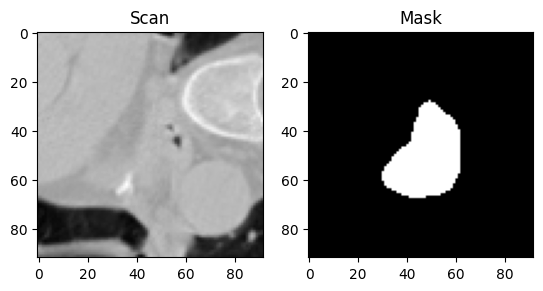

In [ ]:
# Load the scan and mask arrays
archive = np.load('data_9Cbe5hx/images/patient_407.npz')
scan = archive['scan']
mask = archive['mask']

# Choose a slice index to display
slice_index = 47  # Adjust this according to the desired slice

# Display the scan slice
plt.subplot(1, 2, 1)
plt.imshow(scan[:, :, slice_index], cmap='gray')
plt.title('Scan')

# Display the mask slice
plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, slice_index], cmap='gray')
plt.title('Mask')

plt.show()